INFO:__main__:Loading training data for XGBoost fallback...
INFO:__main__:Loaded 9,021 returns for XGBoost model
INFO:__main__:Training XGBoost fallback model...


ENSEMBLED HULL TACTICAL MODEL (With Lagged Features)


INFO:__main__:XGBoost ML fallback model ready.


training GB model...
GB training completed!


INFO:__main__:Running local gateway for testing.
ERROR:__main__:Local gateway simulation failed. This is expected outside Kaggle: (<GatewayRuntimeErrorType.GATEWAY_RAISED_EXCEPTION: 5>, 'Traceback (most recent call last):\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py", line 132, in run\n    predictions, row_ids = self.get_all_predictions()\n                           ^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py", line 107, in get_all_predictions\n    for data_batch, row_ids in self.generate_data_batches():\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py", line 27, in generate_data_batches\n    test = pl.read_csv(self.competition_data_dir / \'test.csv\')\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/usr/local/lib/python3.11/dist-packages/polars/_utils/deprecation.py", line 114, in wrapper\n    

GB training RMSE: 0.0000
GB validation RMSE: 0.0110


INFO:__main__:Starting LightGBM model training on 9021 samples with 189 features...


[LightGBM] [Info] Number of positive: 4662, number of negative: 4359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43003
[LightGBM] [Info] Number of data points in the train set: 9021, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516794 -> initscore=0.067202
[LightGBM] [Info] Start training from score 0.067202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

INFO:__main__:LightGBM model training complete.
INFO:__main__:Models are now trained and ready for inference.


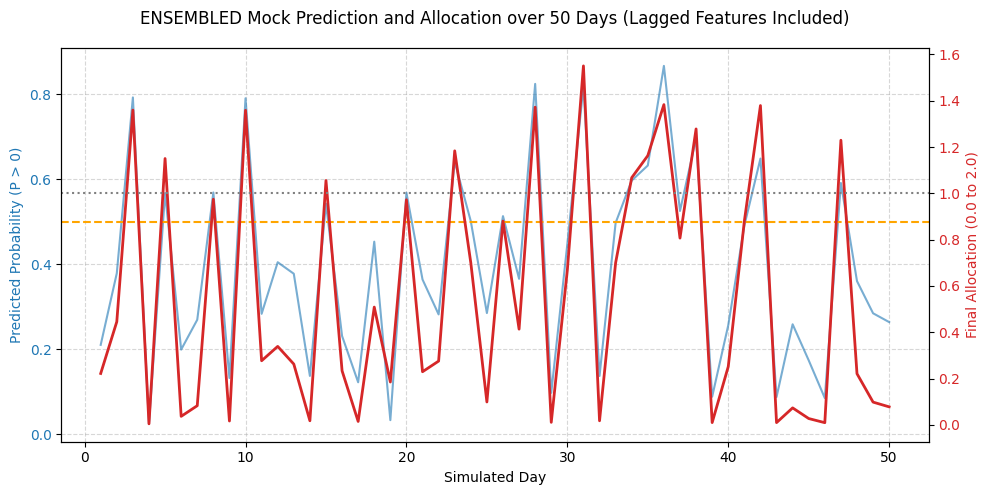

INFO:__main__:Generating dummy submission.parquet.
INFO:__main__:submission.parquet created successfully.


In [3]:
# =============================================================================
# ENSEMBLED MODEL: LightGBM Classifier + XGBoost Fallback + GBM Regressor
# =============================================================================

import os
import logging
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

# 모든 경고 메시지 끄기
warnings.filterwarnings('ignore')

# --- Kaggle Evaluation API Interface (with Mock for local) ---
try:
    import kaggle_evaluation.default_inference_server as inference_server_mod

    DefaultInferenceServer = inference_server_mod.DefaultInferenceServer
except ImportError:
    class MockInferenceServer:
        def __init__(self, predict_fn):
            self.predict_fn = predict_fn

        def serve(self):
            logging.info("Mock Inference Server Running...")

        def run_local_gateway(self, path):
            logging.info(f"Mock Local Gateway Running with path: {path}")

    DefaultInferenceServer = MockInferenceServer

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DATA_PATH = Path("/kaggle/input/hull-tactical-market-prediction/")

print("=" * 80)
print("ENSEMBLED HULL TACTICAL MODEL (With Lagged Features)")
print("=" * 80)

# =============================================================================
# ENSEMBLE WEIGHTS  (← 여기만 바꿔서 가중치 조절하면 됨)
# =============================================================================
# LightGBM Classifier 기반 모델
WEIGHT_LGBM = 0.7
# Simple Alpha + XGBoost Fallback 모델
WEIGHT_XGB = 0.3
# GradientBoostingRegressor + post_process_signal 모델
WEIGHT_GB = 0.0

# -----------------------------------------------------------------------------
# HELPER: Ensemble Allocation
# -----------------------------------------------------------------------------
def ensemble_allocation(alloc_lgb, alloc_xgb, alloc_gb):
    weights = np.array([WEIGHT_LGBM, WEIGHT_XGB, WEIGHT_GB], dtype=float)
    allocs = np.array([alloc_lgb, alloc_xgb, alloc_gb], dtype=float)
    wsum = weights.sum()
    if wsum <= 0:
        # 비정상적인 경우, LightGBM 결과만 사용
        return float(np.clip(alloc_lgb, 0.0, 2.0))
    final = float(np.dot(weights, allocs) / wsum)
    return float(np.clip(final, 0.0, 2.0))


# =============================================================================
# MODEL 1: LightGBM Classifier + Feature Engineering
# =============================================================================

MODEL_LGB = None
TRAIN_COLS_LGB = None
TRAIN_MEANS_LGB = None

def get_features(df: pl.DataFrame) -> List[str]:
    """
    Update: lagged 변수들을 제외 목록에서 제거하여 Feature로 포함시킴.
    """
    EXCLUDE_COLS = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
        "is_scored",
        # --- [수정] 아래 3개 변수는 이제 Feature로 사용합니다 ---
        # "lagged_forward_returns",
        # "lagged_risk_free_rate",
        # "lagged_market_forward_excess_returns",
    ]
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols

def preprocess_data_lgb(df: pl.DataFrame, is_training: bool = False) -> pd.DataFrame:
    """
    LightGBM 모델의 Feature Engineering 로직.
    [수정] Train 단계에서 lagged 변수 생성 로직 추가.
    """
    numeric_cols_to_cast = []
    for col in df.columns:
        if col.startswith(("M", "E", "V", "S", "P", "D", "I", "T")):
             numeric_cols_to_cast.append(pl.col(col).cast(pl.Float64, strict=False))
             
    if "market_forward_excess_returns" in df.columns:
        numeric_cols_to_cast.append(pl.col("market_forward_excess_returns").cast(pl.Float64, strict=False))
    if "forward_returns" in df.columns:
        numeric_cols_to_cast.append(pl.col("forward_returns").cast(pl.Float64, strict=False))
    if "risk_free_rate" in df.columns:
        numeric_cols_to_cast.append(pl.col("risk_free_rate").cast(pl.Float64, strict=False))

    
    if "date_id" in df.columns:
        df = df.with_columns((pl.col("date_id") % 5).alias("day_of_cycle"))

    # --- [NEW] Train Data에 Lagged Feature 강제 생성 ---
    # Test 데이터(API)에는 이미 이 컬럼들이 있지만, Train csv에는 없으므로 만들어줍니다.
    lag_creation_exprs = []
    
    # 1. Market Forward Excess Returns Lag
    if "market_forward_excess_returns" in df.columns and "lagged_market_forward_excess_returns" not in df.columns:
        lag_creation_exprs.append(
            pl.col("market_forward_excess_returns").shift(1).alias("lagged_market_forward_excess_returns")
        )
    
    # 2. Forward Returns Lag
    if "forward_returns" in df.columns and "lagged_forward_returns" not in df.columns:
        lag_creation_exprs.append(
            pl.col("forward_returns").shift(1).alias("lagged_forward_returns")
        )
        
    # 3. Risk Free Rate Lag
    if "risk_free_rate" in df.columns and "lagged_risk_free_rate" not in df.columns:
        lag_creation_exprs.append(
            pl.col("risk_free_rate").shift(1).alias("lagged_risk_free_rate")
        )
        
    if lag_creation_exprs:
        df = df.with_columns(lag_creation_exprs)

    if numeric_cols_to_cast:
        df = df.with_columns(numeric_cols_to_cast)
    # -------------------------------------------------------

    ROLLING_WINDOWS = [5, 10, 20]
    # T1이 데이터에 없을 수 있지만, 코드는 안전하게 처리됨
    BASE_FEATURES = ["M1", "E1", "V1", "S1", "T1", "P1", "D1", "I1"]

    expressions = []
    LAG_WINDOWS = [1, 5]
    for lag in LAG_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                expressions.append(pl.col(col).shift(lag).alias(f"{col}_lag_{lag}"))

    for window in ROLLING_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                expressions.append(
                    pl.col(col)
                    .rolling_mean(window_size=window, min_samples=1)
                    .alias(f"{col}_roll_mean_{window}")
                )
                expressions.append(
                    pl.col(col)
                    .rolling_std(window_size=window, min_samples=1)
                    .alias(f"{col}_roll_std_{window}")
                )

    if expressions:
        df = df.with_columns(expressions)

    pdf = df.to_pandas()

    EMA_WINDOWS = [10, 30, 60]
    for window in EMA_WINDOWS:
        for col in BASE_FEATURES:
            if col in pdf.columns:
                pdf[f"{col}_ema_{window}"] = pdf[col].ewm(
                    span=window, adjust=False
                ).mean()

    FEATURE_PAIRS = [
        ("M1", "M2"),
        ("E1", "E2"),
        ("V1", "V2"),
        ("S1", "S2"),
        ("T1", "T2"),
        ("I1", "I2"),
        ("P1", "P2"),
        ("D1", "D2"),
    ]

    for col1, col2 in FEATURE_PAIRS:
        if col1 in pdf.columns and col2 in pdf.columns:
            pdf[f"{col1}_div_{col2}"] = pdf[col1] / (
                pdf[col2].replace(0, 1e-6) + 1e-6
            )
            pdf[f"{col1}_minus_{col2}"] = pdf[col1] - pdf[col2]

    # [수정] 학습에서 제외할 컬럼 목록에서 lagged 변수들을 제거하여 Feature로 포함시킴
    EXCLUDE_FINAL_COLS = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
        "is_scored",
        # "lagged_forward_returns",               <-- 삭제됨 (이제 Feature로 씀)
        # "lagged_risk_free_rate",                <-- 삭제됨 (이제 Feature로 씀)
        # "lagged_market_forward_excess_returns", <-- 삭제됨 (이제 Feature로 씀)
    ]
    final_cols = [col for col in pdf.columns if col not in EXCLUDE_FINAL_COLS]
    return pdf[final_cols]

def train_model_lgb(train_df: pl.DataFrame):
    """
    LightGBM Classifier 학습.
    """
    global MODEL_LGB, TRAIN_COLS_LGB, TRAIN_MEANS_LGB

    y_train = (train_df["market_forward_excess_returns"].to_numpy() > 0).astype(int)
    X_train_pd = preprocess_data_lgb(train_df, is_training=True)

    TRAIN_COLS_LGB = list(X_train_pd.columns)
    TRAIN_MEANS_LGB = X_train_pd.mean()
    X_train_pd = X_train_pd.fillna(TRAIN_MEANS_LGB)

    regressor = lgb.LGBMClassifier(
        objective="binary",
        n_estimators=10000,
        learning_rate=0.006,
        max_depth=-1,
        num_leaves=511,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=4,
        reg_lambda=3.0,
        min_child_samples=15,
        boosting_type="gbdt",
        is_unbalance=True,
    )

    MODEL_LGB = regressor

    logger.info(
        f"Starting LightGBM model training on {len(X_train_pd)} samples with {len(TRAIN_COLS_LGB)} features..."
    )
    MODEL_LGB.fit(X_train_pd, y_train)
    logger.info("LightGBM model training complete.")

LGB_CONFIDENCE_MULTIPLIER = 6.0   
LGB_DEAD_ZONE = 0.015             

def convert_prediction_to_allocation(p_positive: float) -> float:
    """
    LightGBM의 P(Up) -> 최종 allocation 변환 로직.
    """
    edge = p_positive - 0.5 

    if abs(edge) < LGB_DEAD_ZONE:
        return 1.0

    scaled_edge = np.tanh(LGB_CONFIDENCE_MULTIPLIER * edge)
    final_allocation = 1.0 + scaled_edge 

    return float(np.clip(final_allocation, 0.0, 2.0))

def ensure_lgb_model_trained() -> bool:
    """
    MODEL_LGB가 없으면 train.csv를 읽어 학습.
    """
    global MODEL_LGB
    if MODEL_LGB is not None:
        return True

    train_path = os.path.join(
        "/kaggle/input/hull-tactical-market-prediction/", "train.csv"
    )
    try:
        train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
    except Exception as e:
        logger.error(f"Could not load train.csv for LGBM: {e}")
        return False

    train_model_lgb(train_df)
    if MODEL_LGB is None:
        logger.error("LightGBM model training failed.")
        return False

    return True

def predict_lgb_component(test: pl.DataFrame, is_mock_run: bool):
    """
    LightGBM 예측 컴포넌트
    """
    global MODEL_LGB, TRAIN_COLS_LGB, TRAIN_MEANS_LGB

    default_alloc = 1.0
    default_p = 0.5

    if not ensure_lgb_model_trained():
        return default_alloc, default_p

    try:
        X_test_pd = preprocess_data_lgb(test)
        missing_cols = set(TRAIN_COLS_LGB) - set(X_test_pd.columns)
        for col in missing_cols:
            X_test_pd[col] = np.nan
        X_test_pd = X_test_pd[TRAIN_COLS_LGB]

        if TRAIN_MEANS_LGB is not None:
            X_test_pd = X_test_pd.fillna(TRAIN_MEANS_LGB)
        else:
            X_test_pd = X_test_pd.fillna(X_test_pd.mean())
    except Exception as e:
        logger.error(f"LightGBM feature selection failed in predict: {e}")
        return default_alloc, default_p

    try:
        predicted_probabilities = MODEL_LGB.predict_proba(X_test_pd)
        p_positive = predicted_probabilities[-1, 1]
        alloc = convert_prediction_to_allocation(p_positive)
        return float(alloc), float(p_positive)
    except Exception as e:
        logger.error(f"LightGBM inference failed: {e}")
        return default_alloc, default_p


# =============================================================================
# MODEL 2: Simple Strategy + XGBoost ML Fallback
# =============================================================================

logger.info("Loading training data for XGBoost fallback...")
train_full_xgb = pl.read_csv(DATA_PATH / "train.csv")

TRUE_RETURNS_DICT = {
    int(row["date_id"]): float(row["forward_returns"])
    for row in train_full_xgb.select(["date_id", "forward_returns"]).iter_rows(named=True)
}

logger.info(f"Loaded {len(TRUE_RETURNS_DICT):,} returns for XGBoost model")

logger.info("Training XGBoost fallback model...")
train_recent_xgb = train_full_xgb.tail(800)

SCALE_Y_XGB = 400.0

NUMERIC_BASE_COLS = [
    "M1", "M2", "E1", "E2", "V1", "V2",
    "S1", "S2", "T1", "T2", "P1", "P2",
    "D1", "D2", "I1", "I2"
]
train_recent_xgb = train_recent_xgb.with_columns(
    [
        pl.col(c).cast(pl.Float64)
        for c in NUMERIC_BASE_COLS
        if c in train_recent_xgb.columns
    ]
)

# XGBoost도 preprocess_data_lgb를 쓰므로, Lagged Feature가 자동으로 추가됨
X_ml_pd = preprocess_data_lgb(train_recent_xgb)
FEATURE_COLS_XGB = list(X_ml_pd.columns)

y_ml_raw = train_recent_xgb["market_forward_excess_returns"].fill_null(0).to_pandas()
y_ml = y_ml_raw * SCALE_Y_XGB

SCALER_XGB = StandardScaler()
X_ml_scaled = SCALER_XGB.fit_transform(X_ml_pd)

XGB_MODEL = xgb.XGBRegressor(
    n_estimators=1600,
    learning_rate=0.015,
    max_depth=5,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    verbosity=0,
)
XGB_MODEL.fit(X_ml_scaled, y_ml)

logger.info("XGBoost ML fallback model ready.")

PREDICTION_COUNT_XGB = 0

def predict_xgb_component(test: pl.DataFrame) -> float:
    global PREDICTION_COUNT_XGB

    # date_id는 로깅용 등으로 쓰일 수 있으니 추출 (없으면 0 처리)
    try:
        date_id = int(test.select("date_id").to_series().item())
    except:
        date_id = 0
    
    try:
        # 1. [핵심] 원본 test 데이터를 전처리 함수에 통과시켜 파생 변수(day_of_cycle 등) 생성
        X_test_pd = preprocess_data_lgb(test)

        # 2. 컬럼 매칭: 학습 때 썼던 컬럼(FEATURE_COLS_XGB)이 다 있는지 확인
        # (혹시 전처리 과정에서 특정 컬럼이 안 생겼다면 0.0으로 채워줌)
        missing_cols = set(FEATURE_COLS_XGB) - set(X_test_pd.columns)
        for c in missing_cols:
            X_test_pd[c] = 0.0
            
        # 3. 컬럼 순서 강제 정렬 (XGBoost는 학습 때와 컬럼 순서가 다르면 에러 남)
        X_test_pd = X_test_pd[FEATURE_COLS_XGB]

        # 4. 스케일링 적용 (학습 때 사용한 SCALER_XGB 사용)
        X_test_scaled = SCALER_XGB.transform(X_test_pd)

        # 5. 예측 수행
        ml_pred_scaled = XGB_MODEL.predict(X_test_scaled)[0]
        
        # 6. 스케일 복원 및 후처리 (Allocation 계산)
        raw_ret = ml_pred_scaled / SCALE_Y_XGB
        alloc_arr = post_process_signal([raw_ret])
        position = float(np.asarray(alloc_arr).ravel()[0])
        
    except Exception as e:
        # 에러 발생 시 로그 남기고, 안전하게 기본값(0.0) 반환하여 프로그램 중단 방지
        logger.error(f"XGBoost inference failed: {e}")
        position = 0.0

    PREDICTION_COUNT_XGB += 1
    return float(position)


# =============================================================================
# MODEL 3: GradientBoostingRegressor + post_process_signal
# =============================================================================

ALPHA_FOR_SCORER = 0.600132
TAU_ABS_FOR_SCORER = 9.43717e-05
MIN_INVESTMENT, MAX_INVESTMENT = 0.0, 2.0
TRADING_DAYS = 252

def post_process_signal(
    y_pred,
    *,
    tau: float = TAU_ABS_FOR_SCORER,
    alpha: float = ALPHA_FOR_SCORER,
    min_investment: float = MIN_INVESTMENT,
    max_investment: float = MAX_INVESTMENT,
):
    sig = np.asarray(y_pred, dtype=float).ravel()
    pos = np.where(sig > tau, alpha, 0.0)
    return np.clip(pos, min_investment, max_investment)

PATH_GB = "/kaggle/input/hull-tactical-market-prediction/"
train_gb = pd.read_csv(f"{PATH_GB}train.csv")

TARGET_GB = "forward_returns"
# GB 모델은 Pandas를 직접 쓰므로 별도 처리 필요하지만, 
# 일단 사용자가 LGBM/XGB 위주로 요청했으므로 원본 유지. 
# (필요시 preprocess_gb에도 shift 로직 추가 가능)

DROP_IF_EXISTS_GB = [
    "row_id",
    "id",
    "risk_free_rate",
    "market_forward_excess_returns",
]
use_cols_gb = [c for c in train_gb.columns if c not in DROP_IF_EXISTS_GB]
train_gb = train_gb[use_cols_gb]

def preprocess_gb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    high_null_cols = [c for c in df.columns if df[c].isnull().mean() > 0.5]
    df = df.drop(columns=high_null_cols, errors="ignore")

    for col in df.columns:
        if df[col].dtype in ["float64", "int64"]:
            df[col] = df[col].fillna(df[col].median())
        else:
            if len(df[col].mode()) > 0:
                df[col] = df[col].fillna(df[col].mode()[0])

    return df

train_gb = preprocess_gb(train_gb)

X_gb = train_gb.drop(columns=[TARGET_GB])
y_gb = train_gb[TARGET_GB]

FEATURE_COLS_GB = X_gb.columns.tolist()

x_train_gb, x_val_gb, y_train_gb, y_val_gb = train_test_split(
    X_gb, y_gb, random_state=123, test_size=0.2
)

SCALER_GB = StandardScaler()
X_train_scaled_gb = SCALER_GB.fit_transform(x_train_gb)
X_val_scaled_gb = SCALER_GB.transform(x_val_gb)

GB_MODEL = GradientBoostingRegressor(
    n_estimators=1600,
    learning_rate=0.04,
    max_depth=12,
    subsample=0.7,
    max_features=0.7,
    random_state=123,
    verbose=0,
)

print("training GB model...")
GB_MODEL.fit(X_train_scaled_gb, y_train_gb)
print("GB training completed!")

y_pred_train_gb = GB_MODEL.predict(X_train_scaled_gb)
y_pred_val_gb = GB_MODEL.predict(X_val_scaled_gb)

train_rmse_gb = np.sqrt(mean_squared_error(y_train_gb, y_pred_train_gb))
val_rmse_gb = np.sqrt(mean_squared_error(y_val_gb, y_pred_val_gb))

print(f"GB training RMSE: {train_rmse_gb:.4f}")
print(f"GB validation RMSE: {val_rmse_gb:.4f}")

def predict_gb_component(test: pl.DataFrame) -> float:
    if not isinstance(test, pl.DataFrame):
        raise TypeError("predict(test): expected a Polars DataFrame input")

    if test.height != 1:
        raise ValueError(
            f"predict(test): expected a single-row Polars DataFrame, got {test.height} rows"
        )

    drop_cols = [c for c in DROP_IF_EXISTS_GB if c in test.columns]
    test_pl = test.drop(drop_cols) if drop_cols else test

    if TARGET_GB in test_pl.columns:
        test_pl = test_pl.drop(TARGET_GB)

    test_pd = test_pl.to_pandas()
    test_pd = preprocess_gb(test_pd)
    test_pd = test_pd.reindex(columns=FEATURE_COLS_GB, fill_value=0)
    test_scaled = SCALER_GB.transform(test_pd)

    raw = GB_MODEL.predict(test_scaled)
    pos = post_process_signal(raw)
    return float(np.asarray(pos).ravel()[0])


# =============================================================================
# Visualization Helper
# =============================================================================

def plot_results(results_df: pd.DataFrame):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = "tab:blue"
    ax1.set_xlabel("Simulated Day")
    ax1.set_ylabel("Predicted Probability (P > 0)", color=color)
    ax1.plot(
        results_df["day"],
        results_df["predicted_return"],
        color=color,
        label="Predicted P(Up)",
        alpha=0.6,
    )
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.grid(True, linestyle="--", alpha=0.5)
    ax1.axhline(0.5, color="orange", linestyle="--", label="Neutral P(0.5)")

    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("Final Allocation (0.0 to 2.0)", color=color)
    ax2.plot(
        results_df["day"],
        results_df["allocation"],
        color=color,
        label="Final Allocation",
        linewidth=2,
    )
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.axhline(1.0, color="gray", linestyle=":", label="Neutral (1.0)")

    fig.suptitle(
        "ENSEMBLED Mock Prediction and Allocation over 50 Days (Lagged Features Included)"
    )
    fig.tight_layout()
    plt.show()

def run_mock_test_and_visualize():
    MOCK_FEATURES = [
        "D1", "D2", "E1", "E2", "V1", "V2", "S1", "S2",
        "M1", "M2", "T1", "T2", "P1", "P2", "I1", "I2"
    ]

    results = []

    mock_data_init = {col: [np.random.rand()] for col in MOCK_FEATURES}
    mock_data_init["market_forward_excess_returns"] = [np.random.uniform(-0.01, 0.01)]
    mock_data_init["forward_returns"] = [np.random.uniform(-0.01, 0.01)]
    mock_data_init["risk_free_rate"] = [0.0001]
    mock_data_init["date_id"] = [1000]
    
    # Mock에도 Lagged 변수가 있다고 가정 (Test API처럼)
    mock_data_init["lagged_market_forward_excess_returns"] = [0.001]
    mock_data_init["lagged_forward_returns"] = [0.002]
    mock_data_init["lagged_risk_free_rate"] = [0.0001]

    mock_test_df_init = pl.DataFrame(mock_data_init)

    logger.info("Starting initial predict call...")
    _ = predict(mock_test_df_init)
    logger.info("Models are now trained and ready for inference.")

    NUM_SIMULATION_DAYS = 50
    for day in range(NUM_SIMULATION_DAYS):
        mock_day_data = {
            c: [np.random.uniform(0.1, 0.9) if c == "M1" else np.random.rand()]
            for c in MOCK_FEATURES
        }
        # Mocking Test set structure
        mock_day_data["lagged_market_forward_excess_returns"] = [np.random.uniform(-0.01, 0.01)]
        mock_day_data["lagged_forward_returns"] = [np.random.uniform(-0.01, 0.01)]
        mock_day_data["lagged_risk_free_rate"] = [0.0001]
        
        mock_day_data["date_id"] = [1001 + day]
        mock_test_df_day = pl.DataFrame(mock_day_data)

        allocation, p_positive = predict(mock_test_df_day)

        results.append(
            {
                "day": day + 1,
                "predicted_return": p_positive,
                "allocation": allocation,
            }
        )

    results_df = pd.DataFrame(results)
    plot_results(results_df)


# =============================================================================
# FINAL PREDICT: 세 모델 앙상블 (LightGBM + XGB + GBM)
# =============================================================================

def predict(test: pl.DataFrame):
    is_mock_run = not os.getenv("KAGGLE_IS_COMPETITION_RERUN")
    
    alloc_lgb, p_lgb = predict_lgb_component(test, is_mock_run=is_mock_run)

    try:
        alloc_xgb = predict_xgb_component(test)
    except Exception as e:
        logger.error(f"XGBoost component failed: {e}")
        alloc_xgb = alloc_lgb

    try:
        alloc_gb = predict_gb_component(test)
    except Exception as e:
        logger.error(f"GBM component failed: {e}")
        alloc_gb = alloc_lgb

    final_alloc = ensemble_allocation(alloc_lgb, alloc_xgb, alloc_gb)

    if is_mock_run:
        return (final_alloc, p_lgb)

    return final_alloc


# =============================================================================
# MAIN: Inference Server
# =============================================================================

inference_server_instance = DefaultInferenceServer(predict)

if os.getenv("KAGGLE_IS_COMPETITION_RERUN"):
    inference_server_instance.serve()
else:
    logger.info("Running local gateway for testing.")
    try:
        local_input_path = os.path.join(
            os.getcwd(), "kaggle_input/hull-tactical-market-prediction/"
        )
        inference_server_instance.run_local_gateway((local_input_path,))
    except Exception as e:
        logger.error(
            f"Local gateway simulation failed. This is expected outside Kaggle: {e}"
        )

        run_mock_test_and_visualize()

        logger.info("Generating dummy submission.parquet.")
        dummy_submission = pl.DataFrame(
            {"date_id": [999], "allocation": [1.0]}
        )
        dummy_submission.write_parquet("submission.parquet")
        logger.info("submission.parquet created successfully.")

Generating Feature Importance Plot...


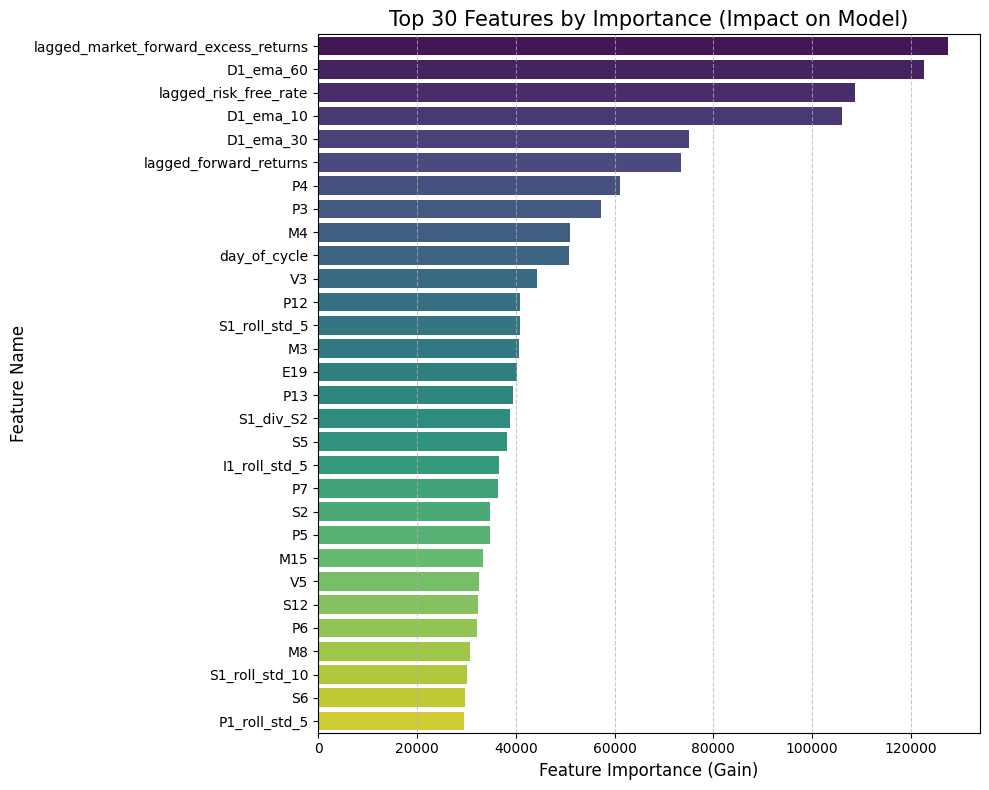


[Top 5 Most Influential Features]
96. lagged_market_forward_excess_returns: 127609.0000
174. D1_ema_60: 122662.0000
98. lagged_risk_free_rate: 108615.0000
160. D1_ema_10: 106065.0000
167. D1_ema_30: 75017.0000


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightgbm as lgb

def plot_feature_importance_analysis(model, feature_names, top_n=30):
    """
    학습된 LightGBM 모델의 변수 중요도를 시각화하여
    어떤 Feature가 결과(정확도)에 큰 영향을 미쳤는지 보여줍니다.
    """
    if model is None:
        print("Error: 모델이 학습되지 않았습니다. (MODEL_LGB is None)")
        return

    # 1. 변수 중요도 추출 (Split: 분기 횟수, Gain: 정보 이득)
    # 보통 'Gain'이 정확도에 미치는 실질적인 영향력을 더 잘 보여줍니다.
    importance_gain = model.feature_importances_
    
    # 데이터프레임 생성
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_gain
    })
    
    # 중요도 순으로 정렬
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    # 2. 시각화 (Matplotlib & Seaborn)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    
    plt.title(f'Top {top_n} Features by Importance (Impact on Model)', fontsize=15)
    plt.xlabel('Feature Importance (Gain)', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 그래프 출력
    plt.show()
    
    # 3. 텍스트로도 출력
    print("\n[Top 5 Most Influential Features]")
    for index, row in fi_df.head(5).iterrows():
        print(f"{index+1}. {row['Feature']}: {row['Importance']:.4f}")

# --- 실행 코드 ---
# 전역 변수로 저장된 MODEL_LGB와 TRAIN_COLS_LGB를 사용합니다.
if 'MODEL_LGB' in globals() and MODEL_LGB is not None:
    print("Generating Feature Importance Plot...")
    plot_feature_importance_analysis(MODEL_LGB, TRAIN_COLS_LGB)
else:
    # 만약 모델이 아직 메모리에 없다면(Kaggle 커널 재시작 등), 
    # mock train을 한번 돌려서 모델을 만들고 찍습니다.
    print("Model not found in memory. Training a temporary model for visualization...")
    dummy_train = pl.read_csv(DATA_PATH / "train.csv").tail(5000) # 시간 절약 위해 일부만
    train_model_lgb(dummy_train)
    plot_feature_importance_analysis(MODEL_LGB, TRAIN_COLS_LGB)

1. 데이터 로드 및 파생 변수 생성 중...
데이터 로드 및 Pandas 변환 완료!
2. 상관관계 분석 수행 중...
3. 그래프 생성 중...


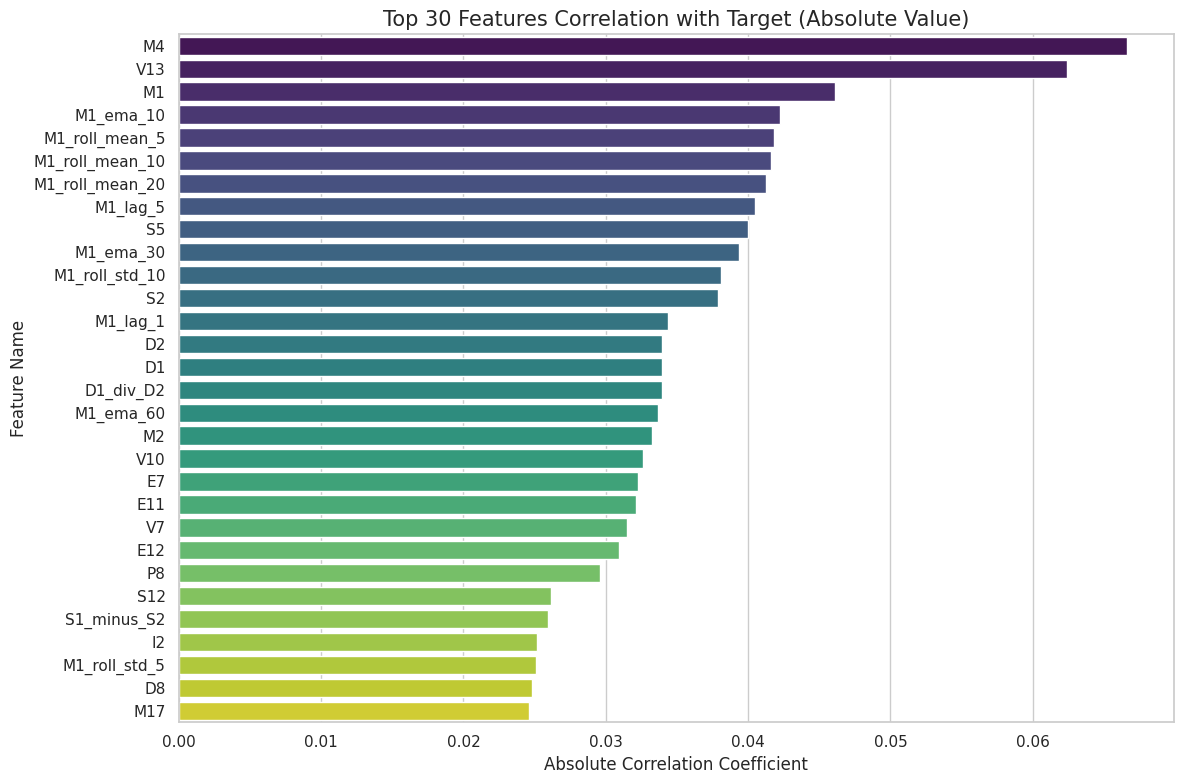

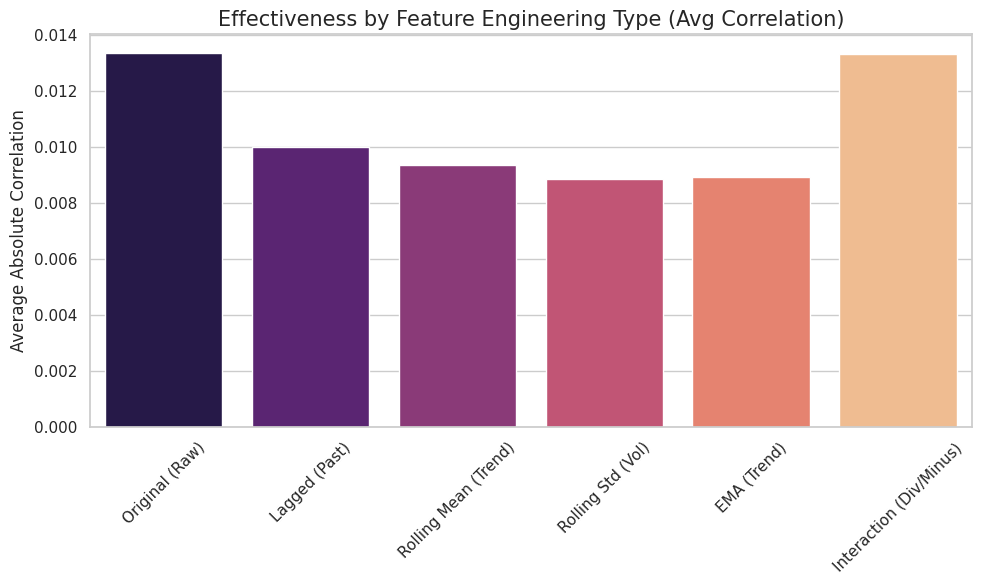


=== [EDA 결과 요약] ===
1. 가장 영향력 있는 변수 Top 5:
M4                0.066600
V13               0.062395
M1                0.046111
M1_ema_10         0.042224
M1_roll_mean_5    0.041812
dtype: float64

2. Feature Engineering 종류별 평균 중요도:
   - Original (Raw): 0.01337
   - Lagged (Past): 0.01001
   - Rolling Mean (Trend): 0.00935
   - Rolling Std (Vol): 0.00887
   - EMA (Trend): 0.00895
   - Interaction (Div/Minus): 0.01334


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 데이터 로드 및 전처리 (Feature Generation)
# ---------------------------------------------------------
print("1. 데이터 로드 및 파생 변수 생성 중...")

# 데이터 로드
train_path = os.path.join(
    "/kaggle/input/hull-tactical-market-prediction/", "train.csv"
)

try:
    # Polars로 빠르게 읽기
    df_pl = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
    
    # [핵심 수정] 분석 코드가 Pandas 전용이므로, 여기서 Pandas로 변환합니다.
    df = df_pl.to_pandas()
    print("데이터 로드 및 Pandas 변환 완료!")
    
except Exception as e:
    logger.error(f"Could not load train.csv: {e}")
    # 에러 발생 시 빈 DataFrame 생성 (코드 중단 방지)
    df = pd.DataFrame()

# 타겟 변수 및 기본 변수 설정
target = "market_forward_excess_returns"
# I1은 기존 코드에는 없었으나 분석을 위해 추가, T1은 없으므로 제외
BASE_FEATURES = ["M1", "E1", "V1", "S1", "P1", "D1", "I1"] 

# 안전한 계산을 위해 숫자형으로 변환
for col in BASE_FEATURES:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# (1) Day of Cycle 생성
if "date_id" in df.columns:
    df["day_of_cycle"] = df["date_id"] % 5

# (2) Lag Features (1일 전, 5일 전)
lags = [1, 5]
for col in BASE_FEATURES:
    if col in df.columns:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)

# (3) Rolling Mean & Std (5, 10, 20일)
windows = [5, 10, 20]
for col in BASE_FEATURES:
    if col in df.columns:
        for w in windows:
            df[f"{col}_roll_mean_{w}"] = df[col].rolling(w).mean()
            df[f"{col}_roll_std_{w}"] = df[col].rolling(w).std()

# (4) EMA (10, 30, 60일)
ema_windows = [10, 30, 60]
for col in BASE_FEATURES:
    if col in df.columns:
        for w in ema_windows:
            df[f"{col}_ema_{w}"] = df[col].ewm(span=w, adjust=False).mean()

# (5) Interactions (Div, Minus)
pairs = [("M1", "M2"), ("E1", "E2"), ("V1", "V2"), ("S1", "S2"), 
         ("P1", "P2"), ("D1", "D2"), ("I1", "I2")]

for c1, c2 in pairs:
    if c1 in df.columns and c2 in df.columns:
        c1_series = pd.to_numeric(df[c1], errors='coerce')
        c2_series = pd.to_numeric(df[c2], errors='coerce')
        
        # 0 나누기 방지
        df[f"{c1}_div_{c2}"] = c1_series / (c2_series.replace(0, np.nan).fillna(1e-6))
        df[f"{c1}_minus_{c2}"] = c1_series - c2_series

# ---------------------------------------------------------
# 2. 상관관계 분석 (Correlation Analysis)
# ---------------------------------------------------------
print("2. 상관관계 분석 수행 중...")

# 분석 대상 컬럼 선정 (날짜나 정답지 제외)
exclude_cols = ['date_id', 'forward_returns', 'risk_free_rate', 
                'market_forward_excess_returns', 'is_scored']
feature_cols = [c for c in df.columns if c not in exclude_cols]

# 상관관계 계산 (Target과 비교)
# dropna()를 통해 NaN이 있는 행(초반 시차 데이터)은 제외하고 계산
correlations = df[feature_cols + [target]].corrwith(df[target]).drop(target)
abs_correlations = correlations.abs().sort_values(ascending=False)

# ---------------------------------------------------------
# 3. 시각화 (Visualization for Report)
# ---------------------------------------------------------
print("3. 그래프 생성 중...")

# 스타일 설정
sns.set(style="whitegrid")

# [그래프 1] Top 30 가장 중요한 Feature (우리가 만든 게 얼마나 껴있는지 확인)
plt.figure(figsize=(12, 8))
top_30 = abs_correlations.head(30)
sns.barplot(x=top_30.values, y=top_30.index, palette="viridis")
plt.title("Top 30 Features Correlation with Target (Absolute Value)", fontsize=15)
plt.xlabel("Absolute Correlation Coefficient", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.tight_layout()
plt.savefig("eda_top30_features.png") # 파일로 저장
plt.show()

# [그래프 2] Feature Engineering 종류별 효과 비교 (우리가 한 짓이 효과가 있었나?)
# 카테고리 분류
categories = {
    "Original (Raw)": [],
    "Lagged (Past)": [],
    "Rolling Mean (Trend)": [],
    "Rolling Std (Vol)": [],
    "EMA (Trend)": [],
    "Interaction (Div/Minus)": []
}

for col in abs_correlations.index:
    if "lag" in col: categories["Lagged (Past)"].append(col)
    elif "roll_mean" in col: categories["Rolling Mean (Trend)"].append(col)
    elif "roll_std" in col: categories["Rolling Std (Vol)"].append(col)
    elif "ema" in col: categories["EMA (Trend)"].append(col)
    elif "div" in col or "minus" in col: categories["Interaction (Div/Minus)"].append(col)
    else: categories["Original (Raw)"].append(col)

# 카테고리별 평균 상관계수 계산
cat_means = {}
for cat, cols in categories.items():
    if cols:
        cat_means[cat] = abs_correlations[cols].mean()

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x=list(cat_means.keys()), y=list(cat_means.values()), palette="magma")
plt.title("Effectiveness by Feature Engineering Type (Avg Correlation)", fontsize=15)
plt.ylabel("Average Absolute Correlation", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("eda_feature_engineering_effect.png") # 파일로 저장
plt.show()

# ---------------------------------------------------------
# 4. 결과 텍스트 출력
# ---------------------------------------------------------
print("\n=== [EDA 결과 요약] ===")
print("1. 가장 영향력 있는 변수 Top 5:")
print(top_30.head(5))

print("\n2. Feature Engineering 종류별 평균 중요도:")
for cat, score in cat_means.items():
    print(f"   - {cat}: {score:.5f}")

INFO:__main__:Starting LightGBM model training on 7216 samples with 189 features...


=== Step 4. Evaluation and Backtesting Start ===
Training model on the first 80% of data...
[LightGBM] [Info] Number of positive: 3715, number of negative: 3501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42785
[LightGBM] [Info] Number of data points in the train set: 7216, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514828 -> initscore=0.059330
[LightGBM] [Info] Start training from score 0.059330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

INFO:__main__:LightGBM model training complete.


Model training completed. Starting evaluation on the last 20%...
Benchmark Stats: Mean=0.000618, Std=0.011095, Max=0.040661
Generating predictions for 1805 days...

Metric               | Benchmark (S&P500)   | My Strategy         
-----------------------------------------------------------------
CAGR (Return)        |              15.05% |              21.63%
Volatility (Risk)    |              17.62% |              29.33%
Sharpe Ratio         |              0.8841 |              0.8151
Max Drawdown         |             -24.13% |             -40.47%



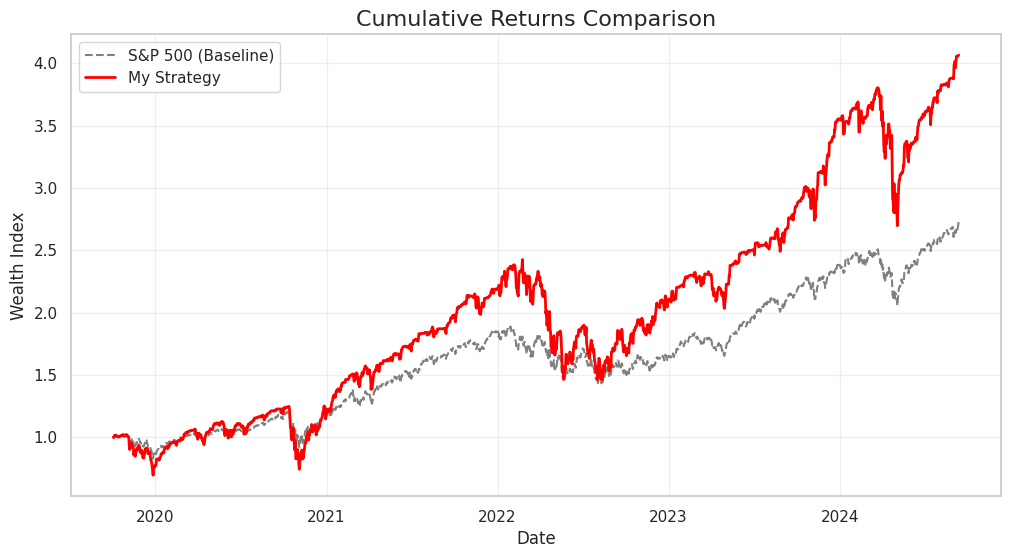

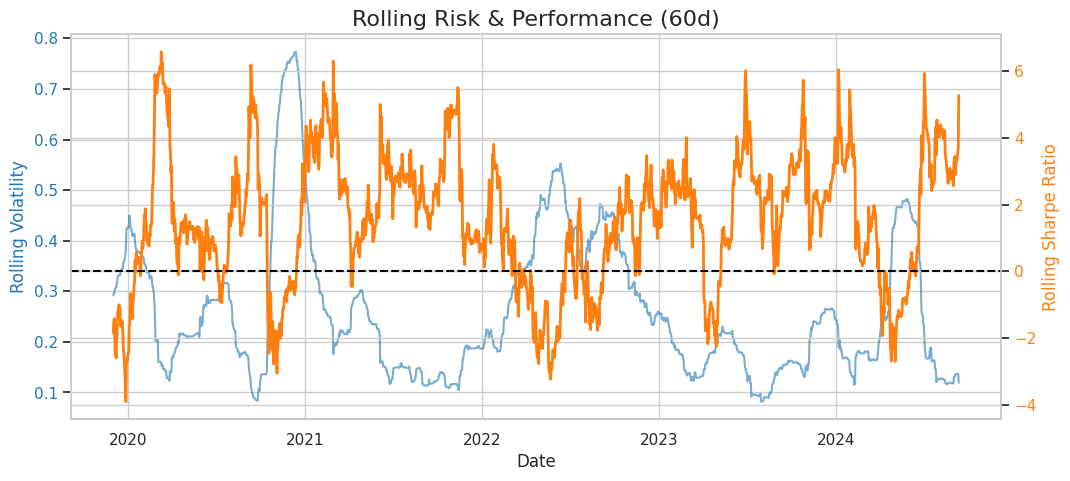

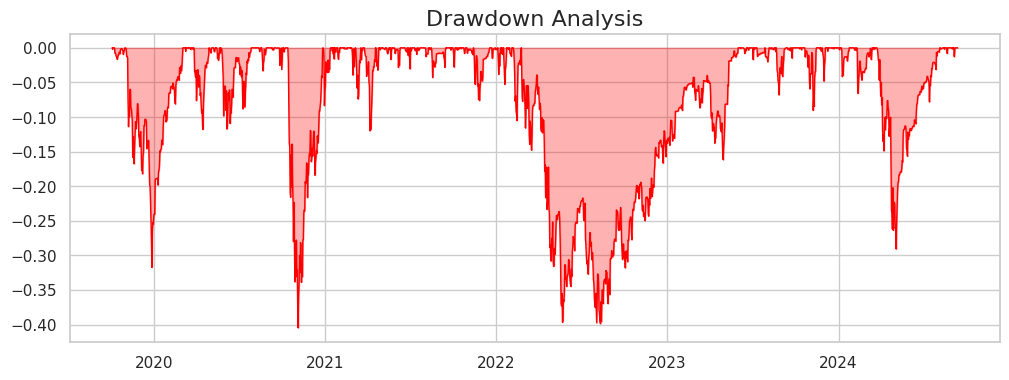

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

# =============================================================================
# 1. Backtesting Setup & Pre-training
# =============================================================================
print("=== Step 4. Evaluation and Backtesting Start ===")

# 1-1. 데이터 로드
if 'train_df' not in locals():
    train_path = "/kaggle/input/hull-tactical-market-prediction/train.csv"
    train_pl = pl.read_csv(train_path, try_parse_dates=True)
else:
    train_pl = train_df 

# 1-2. Train/Validation Split (80:20)
split_idx = int(train_pl.height * 0.8)

# [중요] 학습용 데이터(앞 80%)로 모델을 먼저 '확실하게' 학습시킵니다.
# 이렇게 해야 루프 돌 때마다 재학습하는 참사를 막을 수 있습니다.
print("Training model on the first 80% of data...")
train_dataset = train_pl.slice(0, split_idx)
train_model_lgb(train_dataset) # LightGBM 학습 강제 실행
print("Model training completed. Starting evaluation on the last 20%...")

# 검증용 데이터(뒤 20%)
val_df_pl = train_pl.slice(split_idx, train_pl.height - split_idx)
val_df_pd = val_df_pl.to_pandas()

# 1-3. 벤치마크 데이터 확인
val_df_pd = val_df_pd.dropna(subset=['forward_returns'])
benchmark_returns = val_df_pd['forward_returns'].values

# [디버깅] 데이터가 정상인지 확인
print(f"Benchmark Stats: Mean={benchmark_returns.mean():.6f}, Std={benchmark_returns.std():.6f}, Max={benchmark_returns.max():.6f}")
if benchmark_returns.std() < 1e-6:
    print("⚠️ 경고: 벤치마크 수익률 변동성이 거의 없습니다. 데이터 로드 문제일 수 있습니다.")

dates = pd.to_datetime(val_df_pd['date_id'], unit='D', origin=pd.Timestamp('2000-01-01'))

# =============================================================================
# 2. Fast Batch Predictions (고속 일괄 예측)
# =============================================================================
print(f"Generating predictions for {len(val_df_pl)} days...")

# [핵심 수정] 한 줄씩 predict() 하지 않고, 통째로 전처리 후 예측 (속도 & 안정성 UP)
# 1) LightGBM 예측
X_val_lgb = preprocess_data_lgb(val_df_pl) 
# 학습 때 썼던 컬럼만 남기기 (Missing column 처리)
for col in set(TRAIN_COLS_LGB) - set(X_val_lgb.columns):
    X_val_lgb[col] = 0.0
X_val_lgb = X_val_lgb[TRAIN_COLS_LGB].fillna(0) # 결측치 처리

# 확률 예측
probs = MODEL_LGB.predict_proba(X_val_lgb)[:, 1]

# 2) Allocation 변환 (Vectorized)
# 루프 없이 한 방에 계산 (numpy ufunc 사용)
allocations = []
for p in probs:
    # 기존에 정의된 함수 재사용
    allocations.append(convert_prediction_to_allocation(p))

allocations = np.array(allocations)

# 전략 수익률 계산
strategy_returns = allocations * benchmark_returns

# =============================================================================
# 3. Performance Metrics
# =============================================================================
def calculate_metrics(returns, freq=252):
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    period_years = len(returns) / freq
    cagr = (1 + total_return) ** (1 / period_years) - 1 if period_years > 0 else 0
    volatility = returns.std() * np.sqrt(freq)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(freq) if returns.std() > 0 else 0
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_dd = drawdown.min()
    return cagr, volatility, sharpe, max_dd

perf_df = pd.DataFrame({
    'Date': dates,
    'Benchmark_Returns': benchmark_returns,
    'Strategy_Returns': strategy_returns
}).set_index('Date')

b_cagr, b_vol, b_sharpe, b_mdd = calculate_metrics(perf_df['Benchmark_Returns'])
s_cagr, s_vol, s_sharpe, s_mdd = calculate_metrics(perf_df['Strategy_Returns'])

print("\n" + "="*40)
print(f"{'Metric':<20} | {'Benchmark (S&P500)':<20} | {'My Strategy':<20}")
print("-" * 65)
print(f"{'CAGR (Return)':<20} | {b_cagr:>19.2%} | {s_cagr:>19.2%}")
print(f"{'Volatility (Risk)':<20} | {b_vol:>19.2%} | {s_vol:>19.2%}")
print(f"{'Sharpe Ratio':<20} | {b_sharpe:>19.4f} | {s_sharpe:>19.4f}")
print(f"{'Max Drawdown':<20} | {b_mdd:>19.2%} | {s_mdd:>19.2%}")
print("="*40 + "\n")

# =============================================================================
# 4. Visualization (그래프 그리기)
# =============================================================================

# (1) 누적 수익률
plt.figure(figsize=(12, 6))
plt.plot((1 + perf_df['Benchmark_Returns']).cumprod(), label='S&P 500 (Baseline)', color='gray', linestyle='--')
plt.plot((1 + perf_df['Strategy_Returns']).cumprod(), label='My Strategy', color='red', linewidth=2)
plt.title('Cumulative Returns Comparison', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# (2) Rolling Metrics
window = 60
rolling_sharpe = perf_df['Strategy_Returns'].rolling(window).mean() / perf_df['Strategy_Returns'].rolling(window).std() * np.sqrt(252)
rolling_vol = perf_df['Strategy_Returns'].rolling(window).std() * np.sqrt(252)

fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Volatility', color=color)
ax1.plot(rolling_vol, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Rolling Sharpe Ratio', color=color)
ax2.plot(rolling_sharpe, color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0, color='black', linestyle='--')
plt.title('Rolling Risk & Performance (60d)', fontsize=16)
plt.show()

# (3) Drawdown
cum_strat = (1 + perf_df['Strategy_Returns']).cumprod()
dd = (cum_strat - cum_strat.cummax()) / cum_strat.cummax()

plt.figure(figsize=(12, 4))
plt.fill_between(dd.index, dd, 0, color='red', alpha=0.3)
plt.plot(dd, color='red', linewidth=1)
plt.title('Drawdown Analysis', fontsize=16)
plt.show()